In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


In [2]:
df = pd.read_csv("/kaggle/input/give-me-some-credit-dataset/cs-training.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)

TARGET = "SeriousDlqin2yrs"

In [3]:
df[TARGET].value_counts()

SeriousDlqin2yrs
0    139974
1     10026
Name: count, dtype: int64

In [4]:
num_cols = df.columns.drop(TARGET)


imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])

In [5]:
for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

In [6]:
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

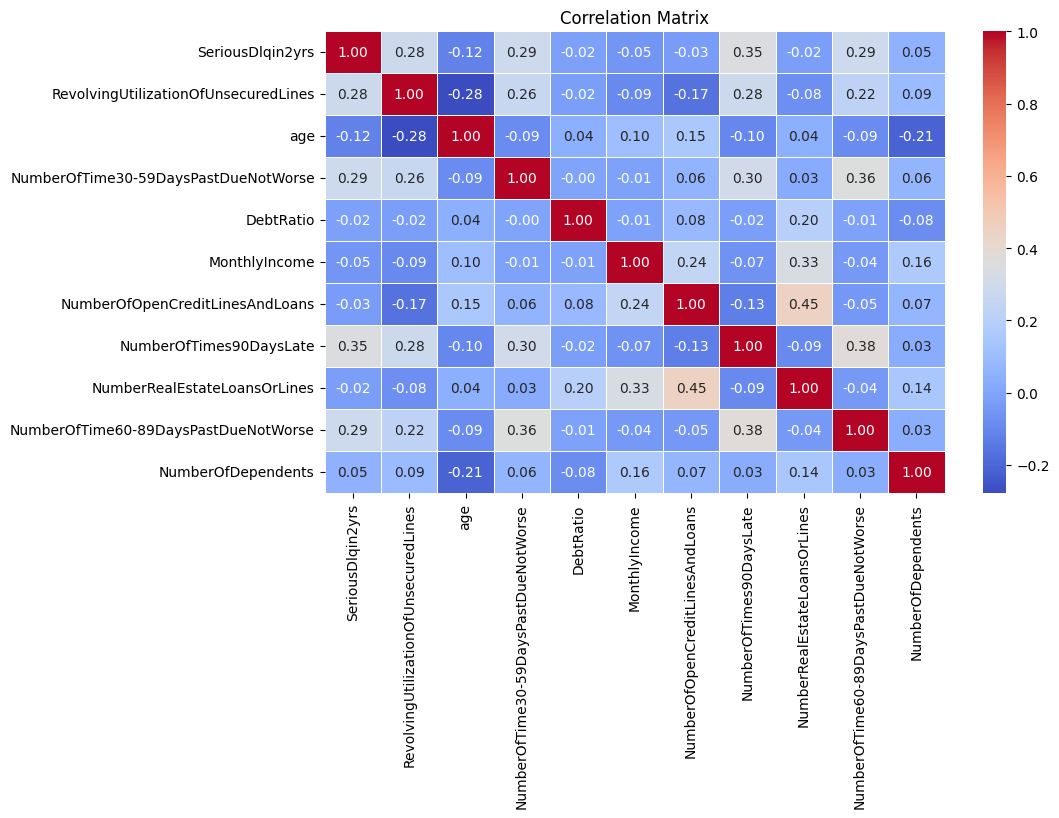

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df.corr(),
    cmap="coolwarm",
    annot=True,        
    fmt=".2f",         
    linewidths=0.5
)
plt.title("Correlation Matrix")
plt.show()


In [8]:
X = df.drop(TARGET, axis=1)
y = df[TARGET]

rfe_estimator = RandomForestClassifier(n_estimators=100, random_state=42)
rfe = RFE(rfe_estimator, n_features_to_select=8)
rfe.fit(X, y)

X = X.loc[:, rfe.support_]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [11]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [12]:
xgb_params = {
    "max_depth": [3],
    "learning_rate": [0.1],
    "n_estimators": [150]
}

xgb_base = xgb.XGBClassifier(
    tree_method="hist",   
    device="cuda",        
    eval_metric="logloss",
    verbosity=0,
    random_state=42
)

xgb_grid = GridSearchCV(
    xgb_base,
    xgb_params,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

xgb_grid.fit(X_train_sm, y_train_sm)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device='cuda',
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     gro...
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [150]},
             scoring='roc_auc')

In [13]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lgb_grid = GridSearchCV(
    lgb.LGBMClassifier(
        device="cpu",
        verbose=-1,
        force_col_wise=True
    ),
    {
        "num_leaves": [31],
        "learning_rate": [0.1],
        "n_estimators": [150]
    },
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

lgb_grid.fit(X_train_sm, y_train_sm)


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LGBMClassifier(device='cpu', force_col_wise=True,
                                      verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'n_estimators': [150],
                         'num_leaves': [31]},
             scoring='roc_auc')

In [14]:
import time

def train_evaluate(model, name, fit_model=True):
    start = time.time()

    if fit_model:
        model.fit(X_train_sm, y_train_sm)

    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    end = time.time()

    print(f"\n===== {name} =====")
    print(f"Training + Inference Time: {end - start:.2f} seconds")
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_test, y_pred):.4f}")
    print(f"F1-score : {f1_score(y_test, y_pred):.4f}")
    print(f"AUC      : {roc_auc_score(y_test, y_prob):.4f}")

    return {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_prob),
        "Time (s)": end - start
    }


In [15]:
res_lr = train_evaluate(
    LogisticRegression(max_iter=1000),
    "Logistic Regression"
)



===== Logistic Regression =====
Training + Inference Time: 0.45 seconds
Accuracy : 0.8037
Precision: 0.2184
Recall   : 0.7511
F1-score : 0.3384
AUC      : 0.8615


In [16]:
res_dt = train_evaluate(
    DecisionTreeClassifier(random_state=42),
    "Decision Tree"
)



===== Decision Tree =====
Training + Inference Time: 2.74 seconds
Accuracy : 0.8694
Precision: 0.2221
Recall   : 0.3815
F1-score : 0.2808
AUC      : 0.6432


In [17]:
res_rf = train_evaluate(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Random Forest"
)


===== Random Forest =====
Training + Inference Time: 39.34 seconds
Accuracy : 0.9058
Precision: 0.3417
Recall   : 0.4424
F1-score : 0.3856
AUC      : 0.8353


In [18]:
res_gb = train_evaluate(
    GradientBoostingClassifier(random_state=42),
    "Gradient Boosting"
)


===== Gradient Boosting =====
Training + Inference Time: 53.69 seconds
Accuracy : 0.8444
Precision: 0.2551
Recall   : 0.6918
F1-score : 0.3727
AUC      : 0.8620


In [19]:
res_xgb = train_evaluate(
    xgb_grid.best_estimator_,
    "XGBoost",
    fit_model=False
)



===== XGBoost =====
Training + Inference Time: 0.02 seconds
Accuracy : 0.8636
Precision: 0.2797
Recall   : 0.6603
F1-score : 0.3929
AUC      : 0.8613


In [20]:
res_lgb = train_evaluate(
    lgb_grid.best_estimator_,
    "LightGBM",
    fit_model=False
)


===== LightGBM =====
Training + Inference Time: 0.37 seconds
Accuracy : 0.9279
Precision: 0.4518
Recall   : 0.3696
F1-score : 0.4066
AUC      : 0.8570


In [21]:
results_df = pd.DataFrame([
    res_lr, res_dt, res_rf, res_gb, res_xgb, res_lgb
]).sort_values("AUC", ascending=False)

results_df


,Model,Accuracy,Precision,Recall,F1,AUC,Time (s)
3,Gradient Boosting,0.844367,0.255057,0.691771,0.372699,0.862037,53.686270
0,Logistic Regression,0.803667,0.218356,0.751122,0.338351,0.861489,0.452546
4,XGBoost,0.863633,0.279679,0.660349,0.392937,0.861316,0.019496
5,LightGBM,0.927900,0.451829,0.369576,0.406584,0.857041,0.366271
2,Random Forest,0.905767,0.341680,0.442394,0.385568,0.835326,39.335277
1,Decision Tree,0.869367,0.222125,0.381546,0.280785,0.643152,2.743078


In [22]:
trained_models = {}

trained_models["Logistic Regression"] = LogisticRegression(max_iter=1000)
trained_models["Logistic Regression"].fit(X_train_sm, y_train_sm)

trained_models["Decision Tree"] = DecisionTreeClassifier(random_state=42)
trained_models["Decision Tree"].fit(X_train_sm, y_train_sm)

trained_models["Random Forest"] = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
trained_models["Random Forest"].fit(X_train_sm, y_train_sm)

trained_models["Gradient Boosting"] = GradientBoostingClassifier(random_state=42)
trained_models["Gradient Boosting"].fit(X_train_sm, y_train_sm)

# Already trained via GridSearch
trained_models["XGBoost"] = xgb_grid.best_estimator_
trained_models["LightGBM"] = lgb_grid.best_estimator_


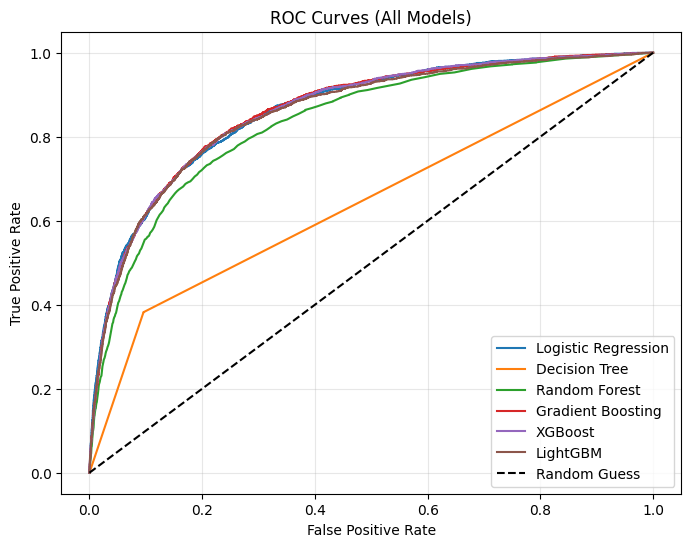

In [23]:
plt.figure(figsize=(8, 6))

for name, model in trained_models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (All Models)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


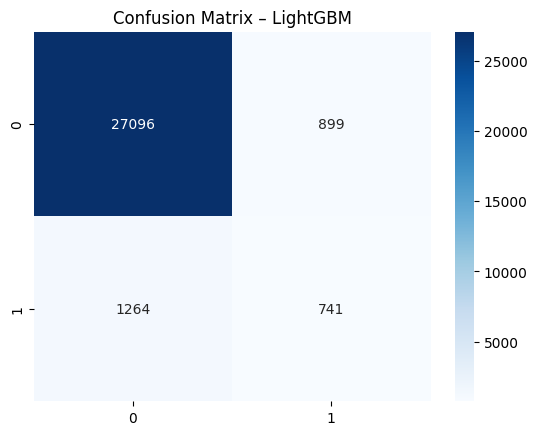

In [24]:
best_model = trained_models["LightGBM"] 

cm = confusion_matrix(y_test, best_model.predict(X_test))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – LightGBM")
plt.show()